# Benchmark: Schoof in-house dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

/home/rasmus/sollertis/school/s11/thesis/protVI/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


In [2]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Data loading

Let's define the path to the data and load it into anndata.

In [3]:
DATA_DIR = "../../data/processed/"

In [4]:
DATA_PATH = os.path.join(DATA_DIR, "schoof_protein_pca.h5ad")

In [5]:
adata = sc.read(DATA_PATH)

In [6]:
adata.layers["raw_sn"] = adata.layers["log2_raw_sn"].copy()
adata.layers["raw_sn"][np.isnan(adata.layers["median_ratios"])] = np.nan

## PROTVI

### Training

Let's now train the model.

In [7]:
adata.X = adata.layers["raw_sn"].copy()
adata.X[np.isnan(adata.X)] = 0

In [8]:
PROTVI.setup_anndata(adata, 
                     batch_key="Plate",
                     categorical_covariate_keys = ['Channel', 'File ID'],
                     continuous_covariate_keys=["Num Proteins","Log2 Sum S/N"], 
                    )

model = PROTVI(adata, log_variational=False, n_hidden=32, n_layers=1, n_latent=10, decoder_type="selection")
#model.view_anndata_setup()

Let's train the model.

In [9]:
model.train(max_epochs=5000, plan_kwargs={"mechanism_weight":0, "kl_weight":120}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 10, "max_kl_weight": 10}),  "lr": 1e-3

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5000/5000: 100%|██████████| 5000/5000 [24:32<00:00,  3.52it/s, v_num=1, train_loss_step=750, train_loss_epoch=757]    

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 5000/5000: 100%|██████████| 5000/5000 [24:32<00:00,  3.40it/s, v_num=1, train_loss_step=750, train_loss_epoch=757]


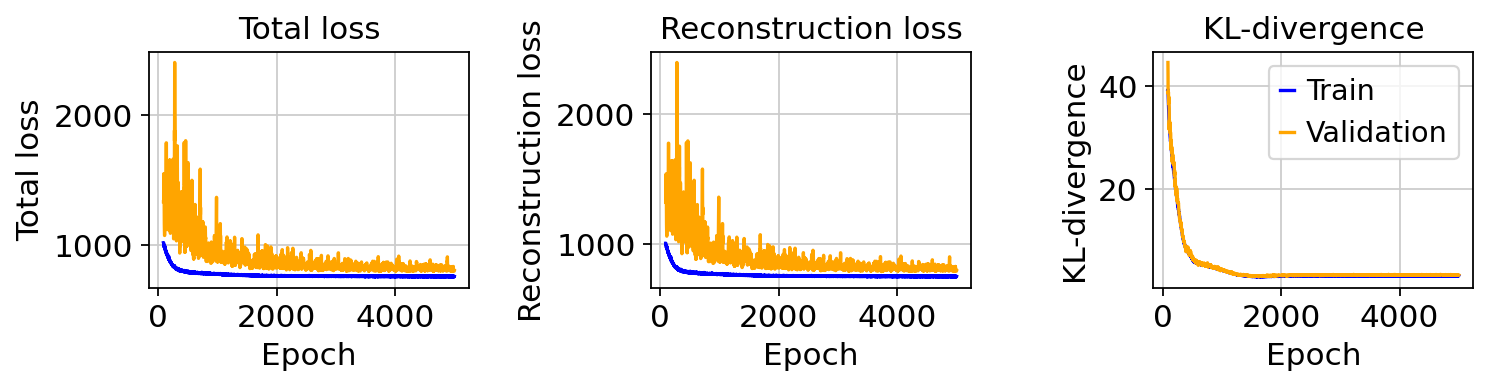

In [10]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

In [ ]:
model.save("schoof_baseline")

In [ ]:
model = PROTVI.load("schoof_baseline", adata)

INFO     File schoof_baseline/model.pt already downloaded                                                          


### Evaluation on training set

In [11]:
x_est, p_est, x_var = model.impute()

x_data = adata.layers["raw_sn"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

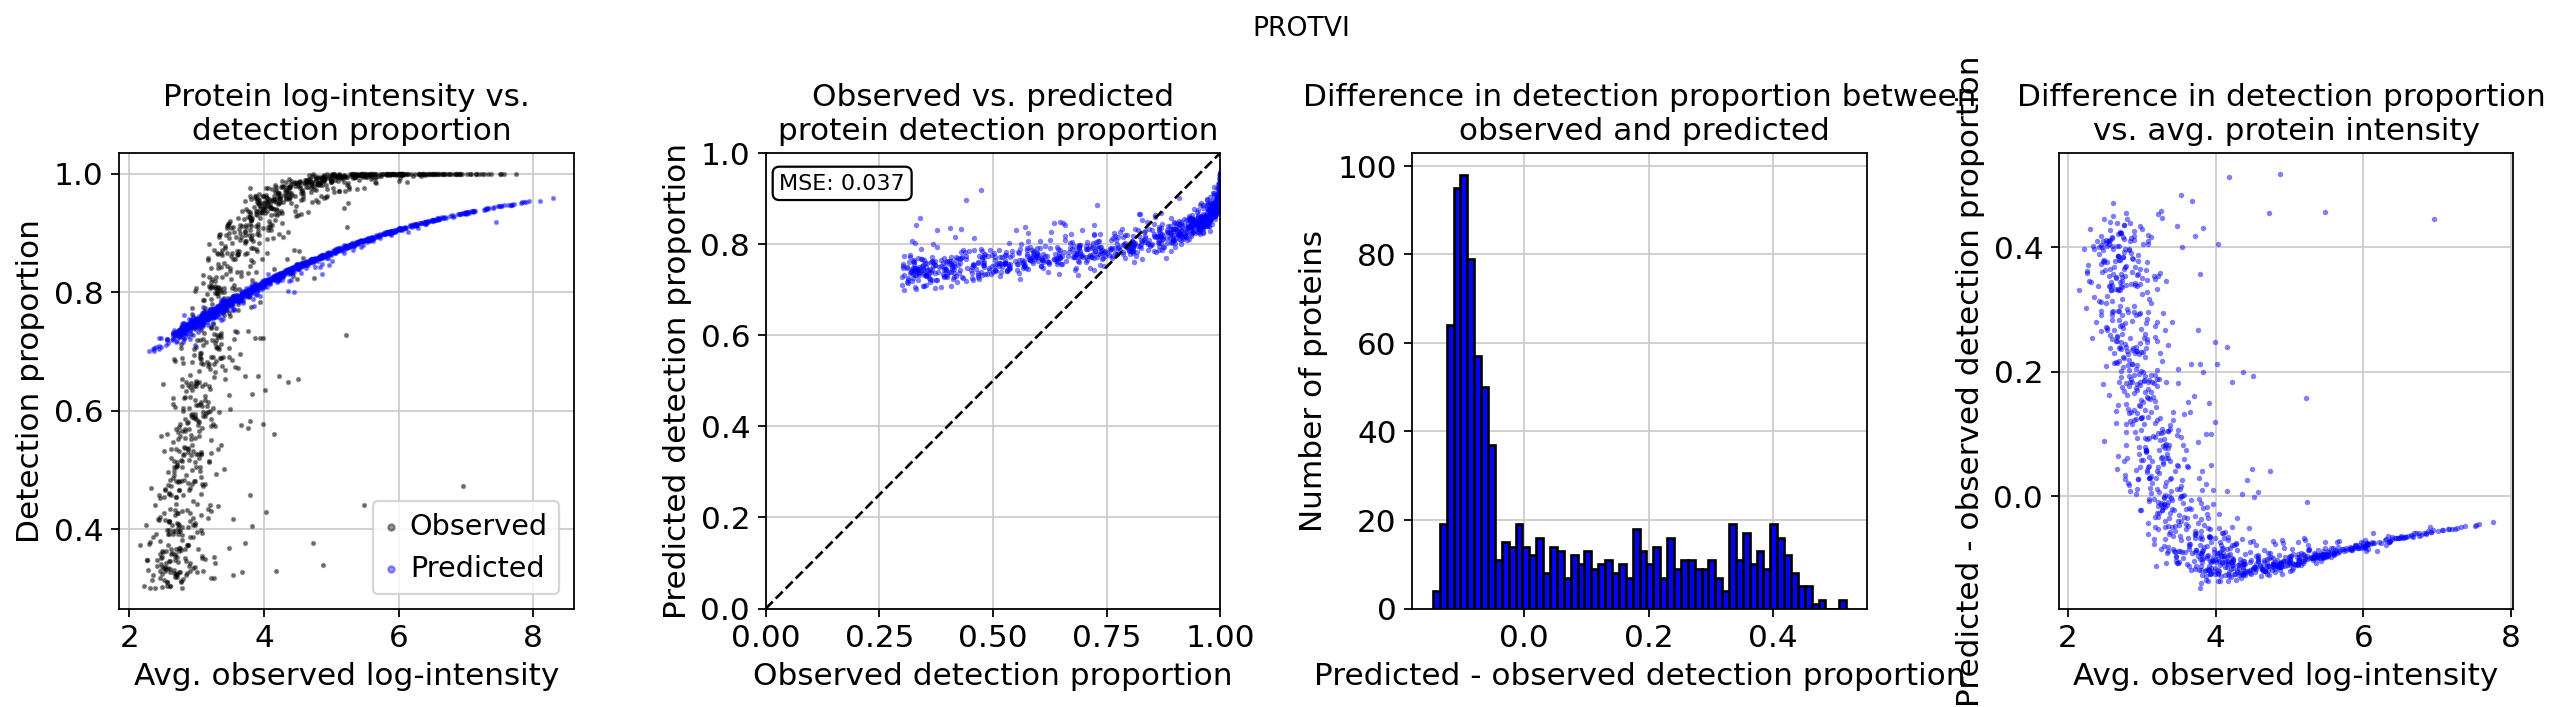

In [12]:
pl.plot_protein_detection_proportion_panel(x_data, p_est, x_est=x_est_obs)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

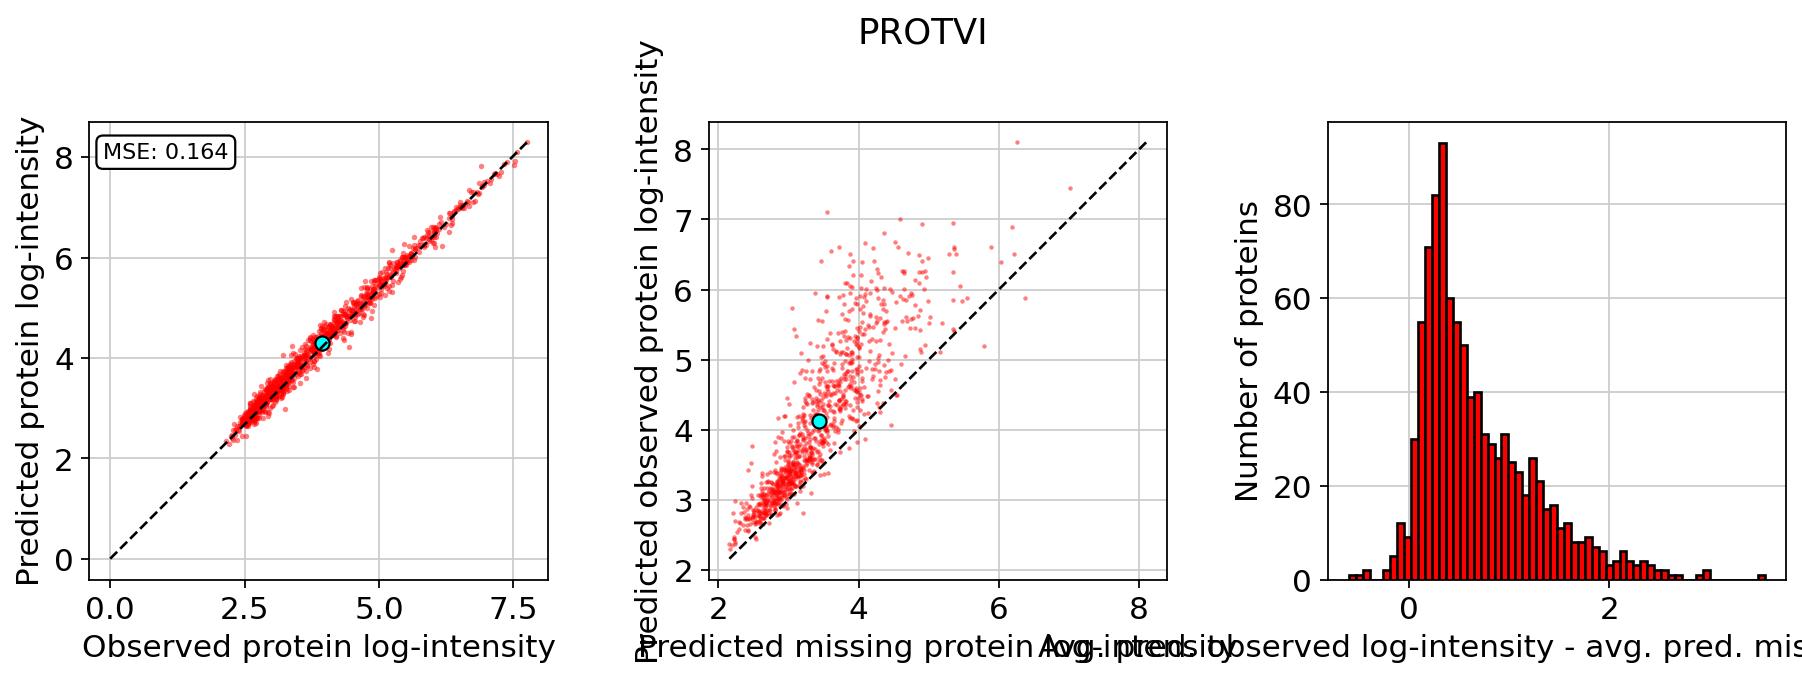

In [13]:
pl.plot_protein_intensity_panel(x_data, x_est)

Let's look at the latent space.

In [14]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

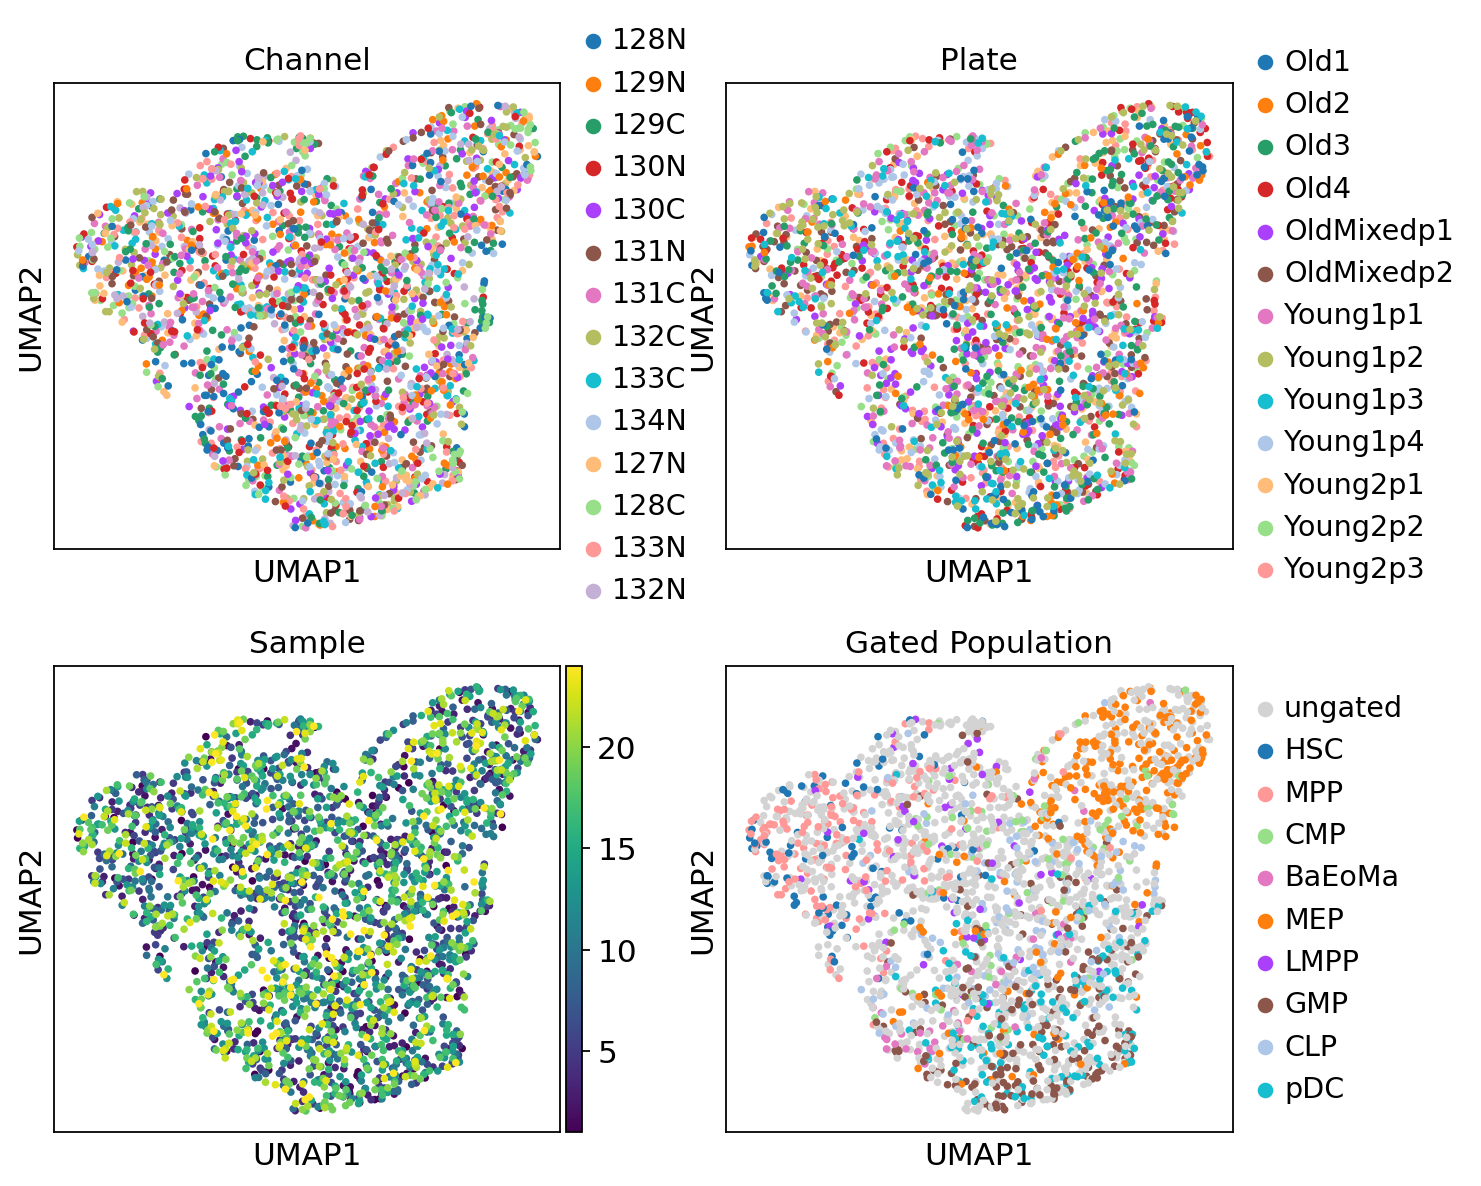

In [15]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Channel", "Plate", "Sample","Gated Population"], ncols=2,
    vmin="p01", vmax="p99",
)

In [16]:
adata = adata[adata.obs["cell_type"].argsort()]

In [17]:
adata.obs["Plate"] = adata.obs["Plate"].cat.rename_categories({x: f"p{i+1}" for i, x in enumerate(adata.obs["Plate"].cat.categories)})
adata.obs["Cell type"] = adata.obs["cell_type"]

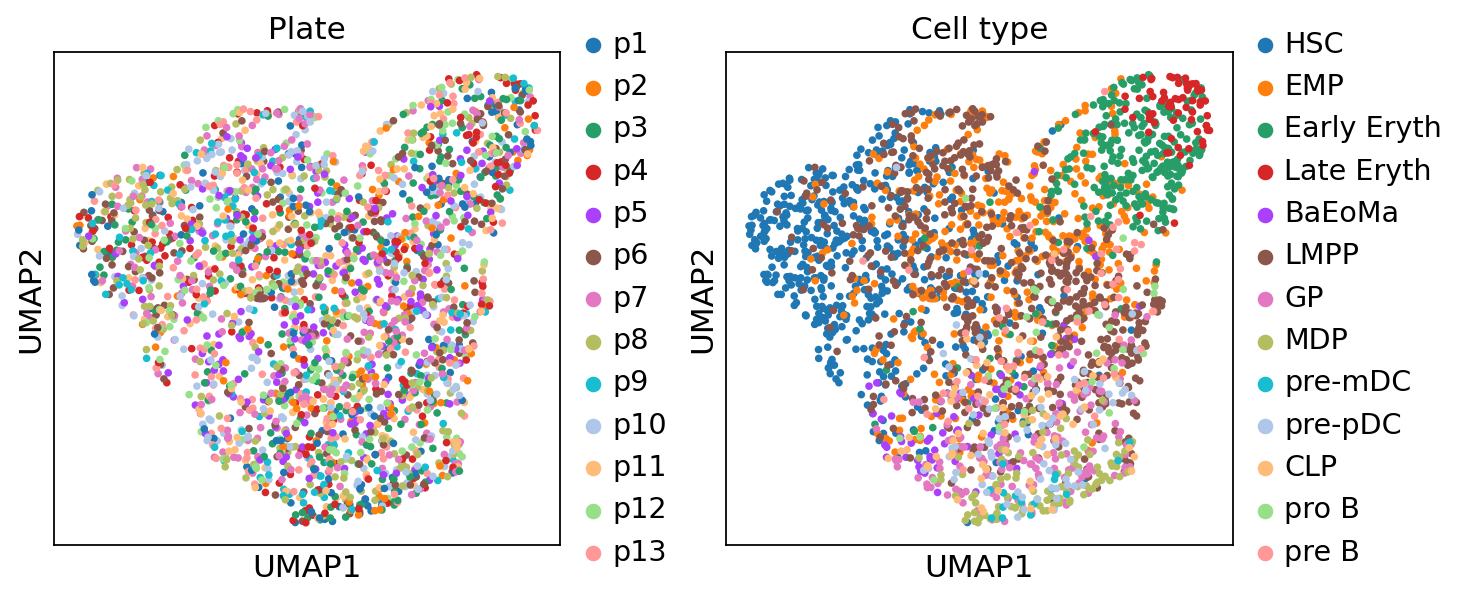

In [18]:
sc.pl.umap(
    adata, 
    color=["Plate", "Cell type"], ncols=2,
    vmin="p01", vmax="p99",
    save="schoof_protvi_all.png"
)

In [19]:
color_map = {
    "HSC": "blue",
    "EMP": "orange",
    "Early Eryth": "green",
    "Late Eryth": "red",
    "BaEoMa": "purple",
    "LMPP": "brown",
    "GP": "pink",
    "MDP": "olive",
    "pre-mDC": "cyan",
    "pre-pDC": "gray",
    "CLP": "orange",
    "pro B": "palegreen",
    "pre B": "tomato"
}

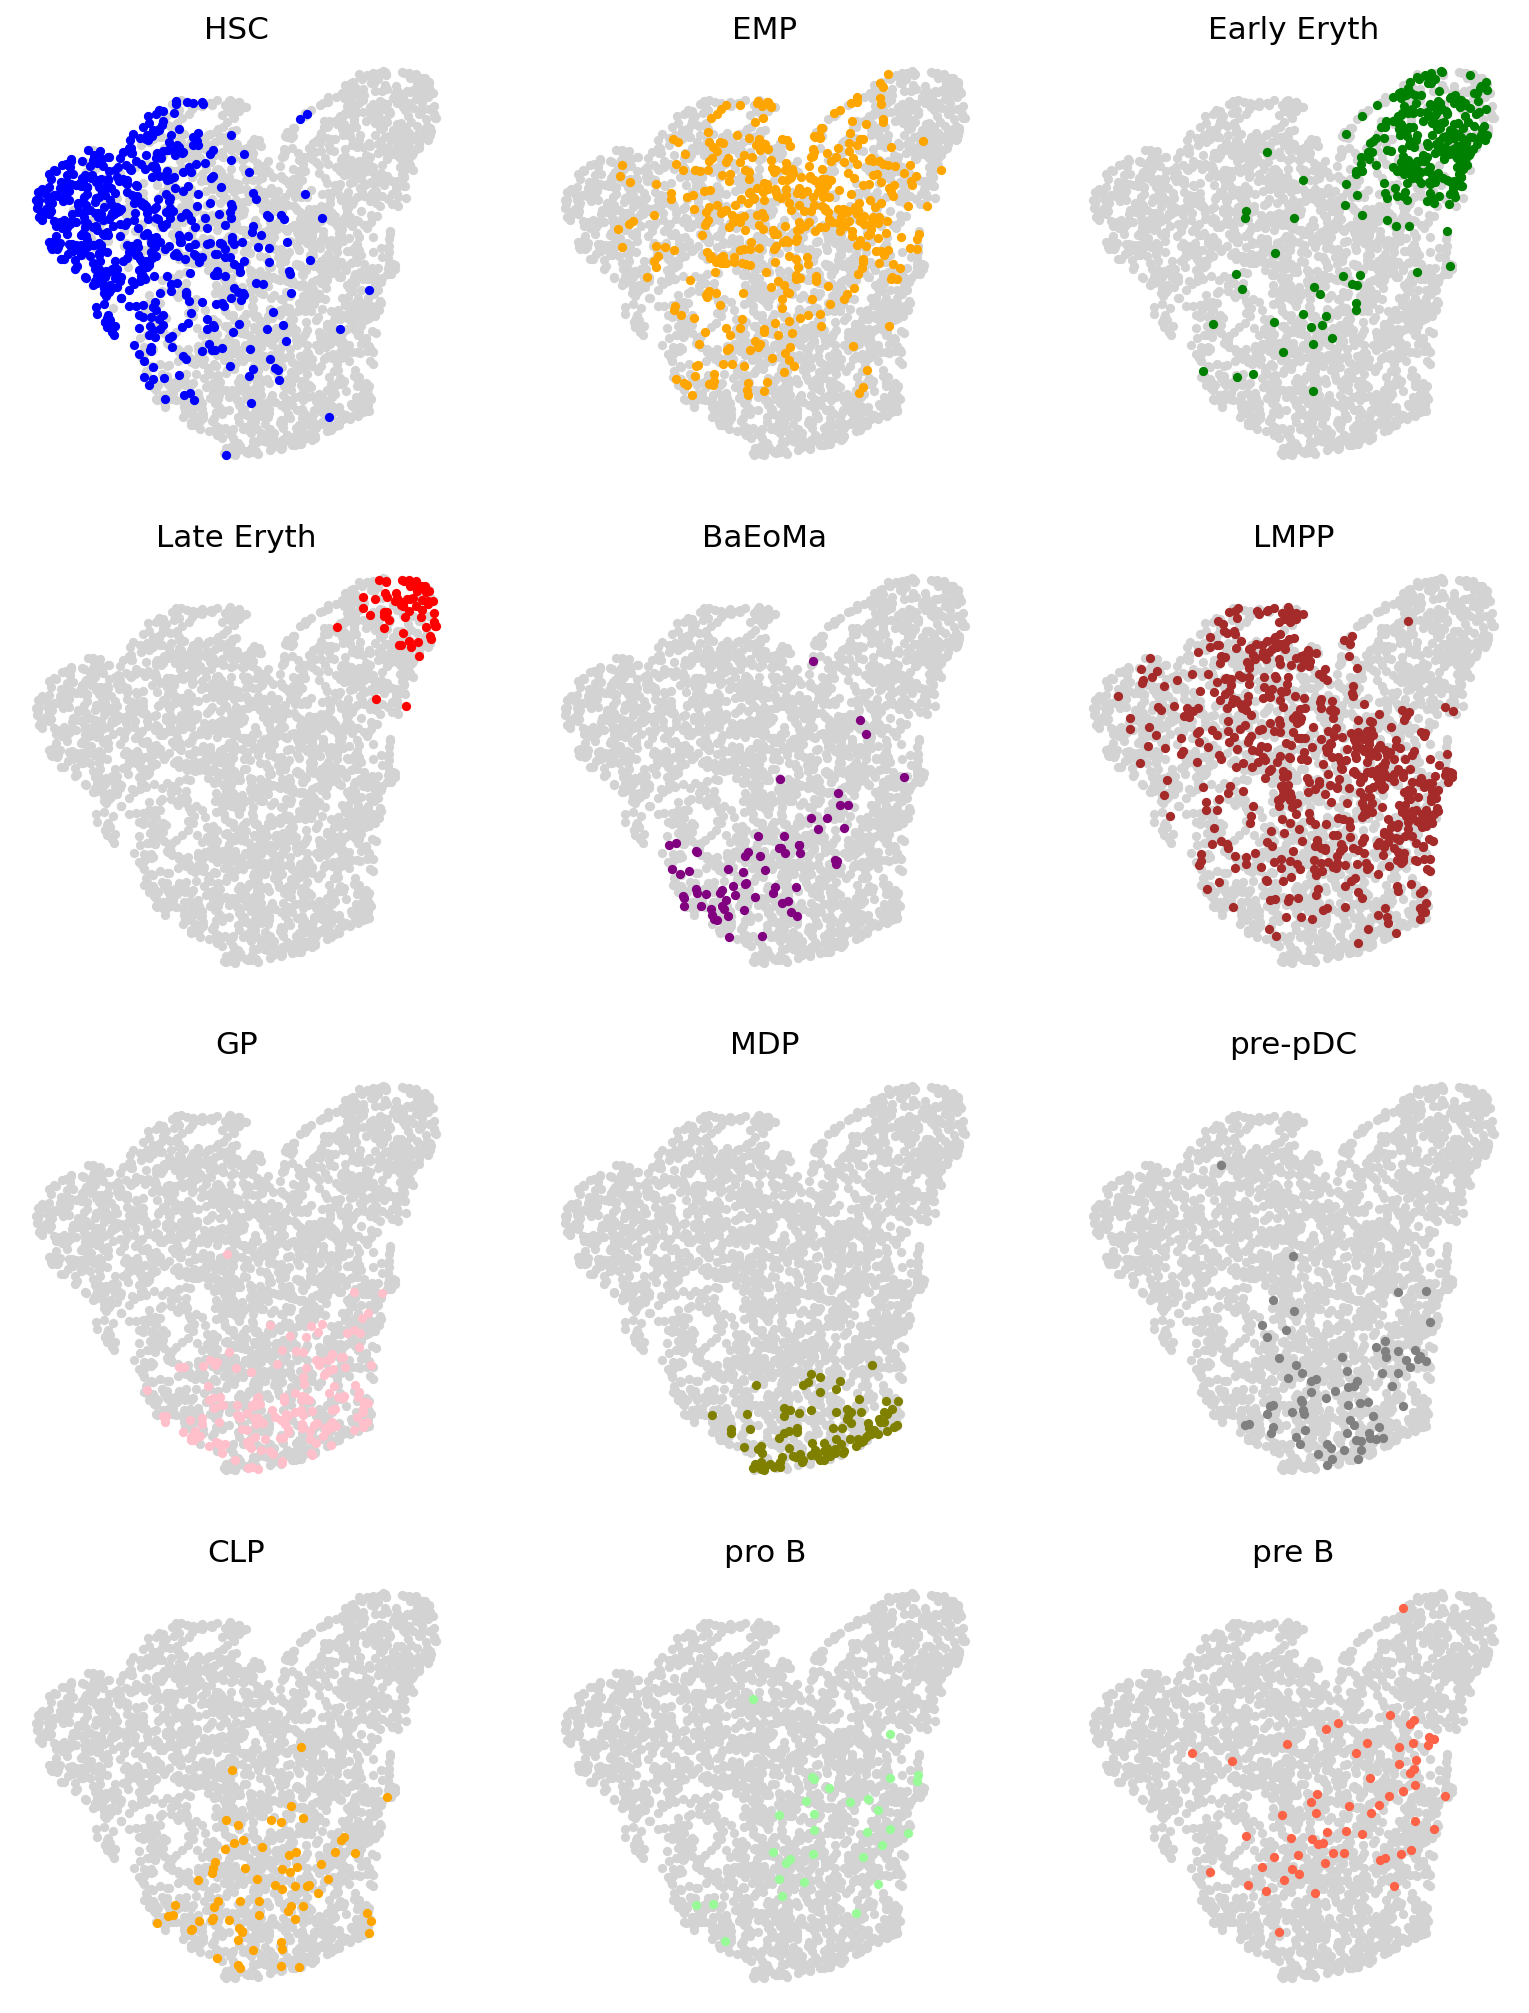

In [20]:
annotation = "cell_type"
categories = adata.obs[annotation].unique()
categories = categories[categories != "pre-mDC"]

n_elements = len(categories)

n_cols = 3
n_rows = n_elements // n_cols
n_rows += 1 if n_elements % n_cols != 0 else 0

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

colors = sns.color_palette("Set1", n_colors=n_elements)

for i, group in enumerate(categories):
    mask = adata.obs[annotation] == group

    ax = axes[i // n_cols, i % n_cols]

    umap = adata.obsm["X_umap"][~mask]

    ax.scatter(
        umap[:, 0],
        umap[:, 1],
        c = "lightgrey",
        s=10, 
    )

    umap = adata.obsm["X_umap"][mask]
    ax.scatter(
        umap[:, 0],
        umap[:, 1],
        c = color_map[group],
        s=10, 
    )

    ax.set_title(group, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

for i in range(n_elements, n_cols * n_rows):
    axes[i // n_cols, i % n_cols].axis("off")

fig.savefig("schoof_protvi_cell_type.png", bbox_inches="tight", dpi=200)

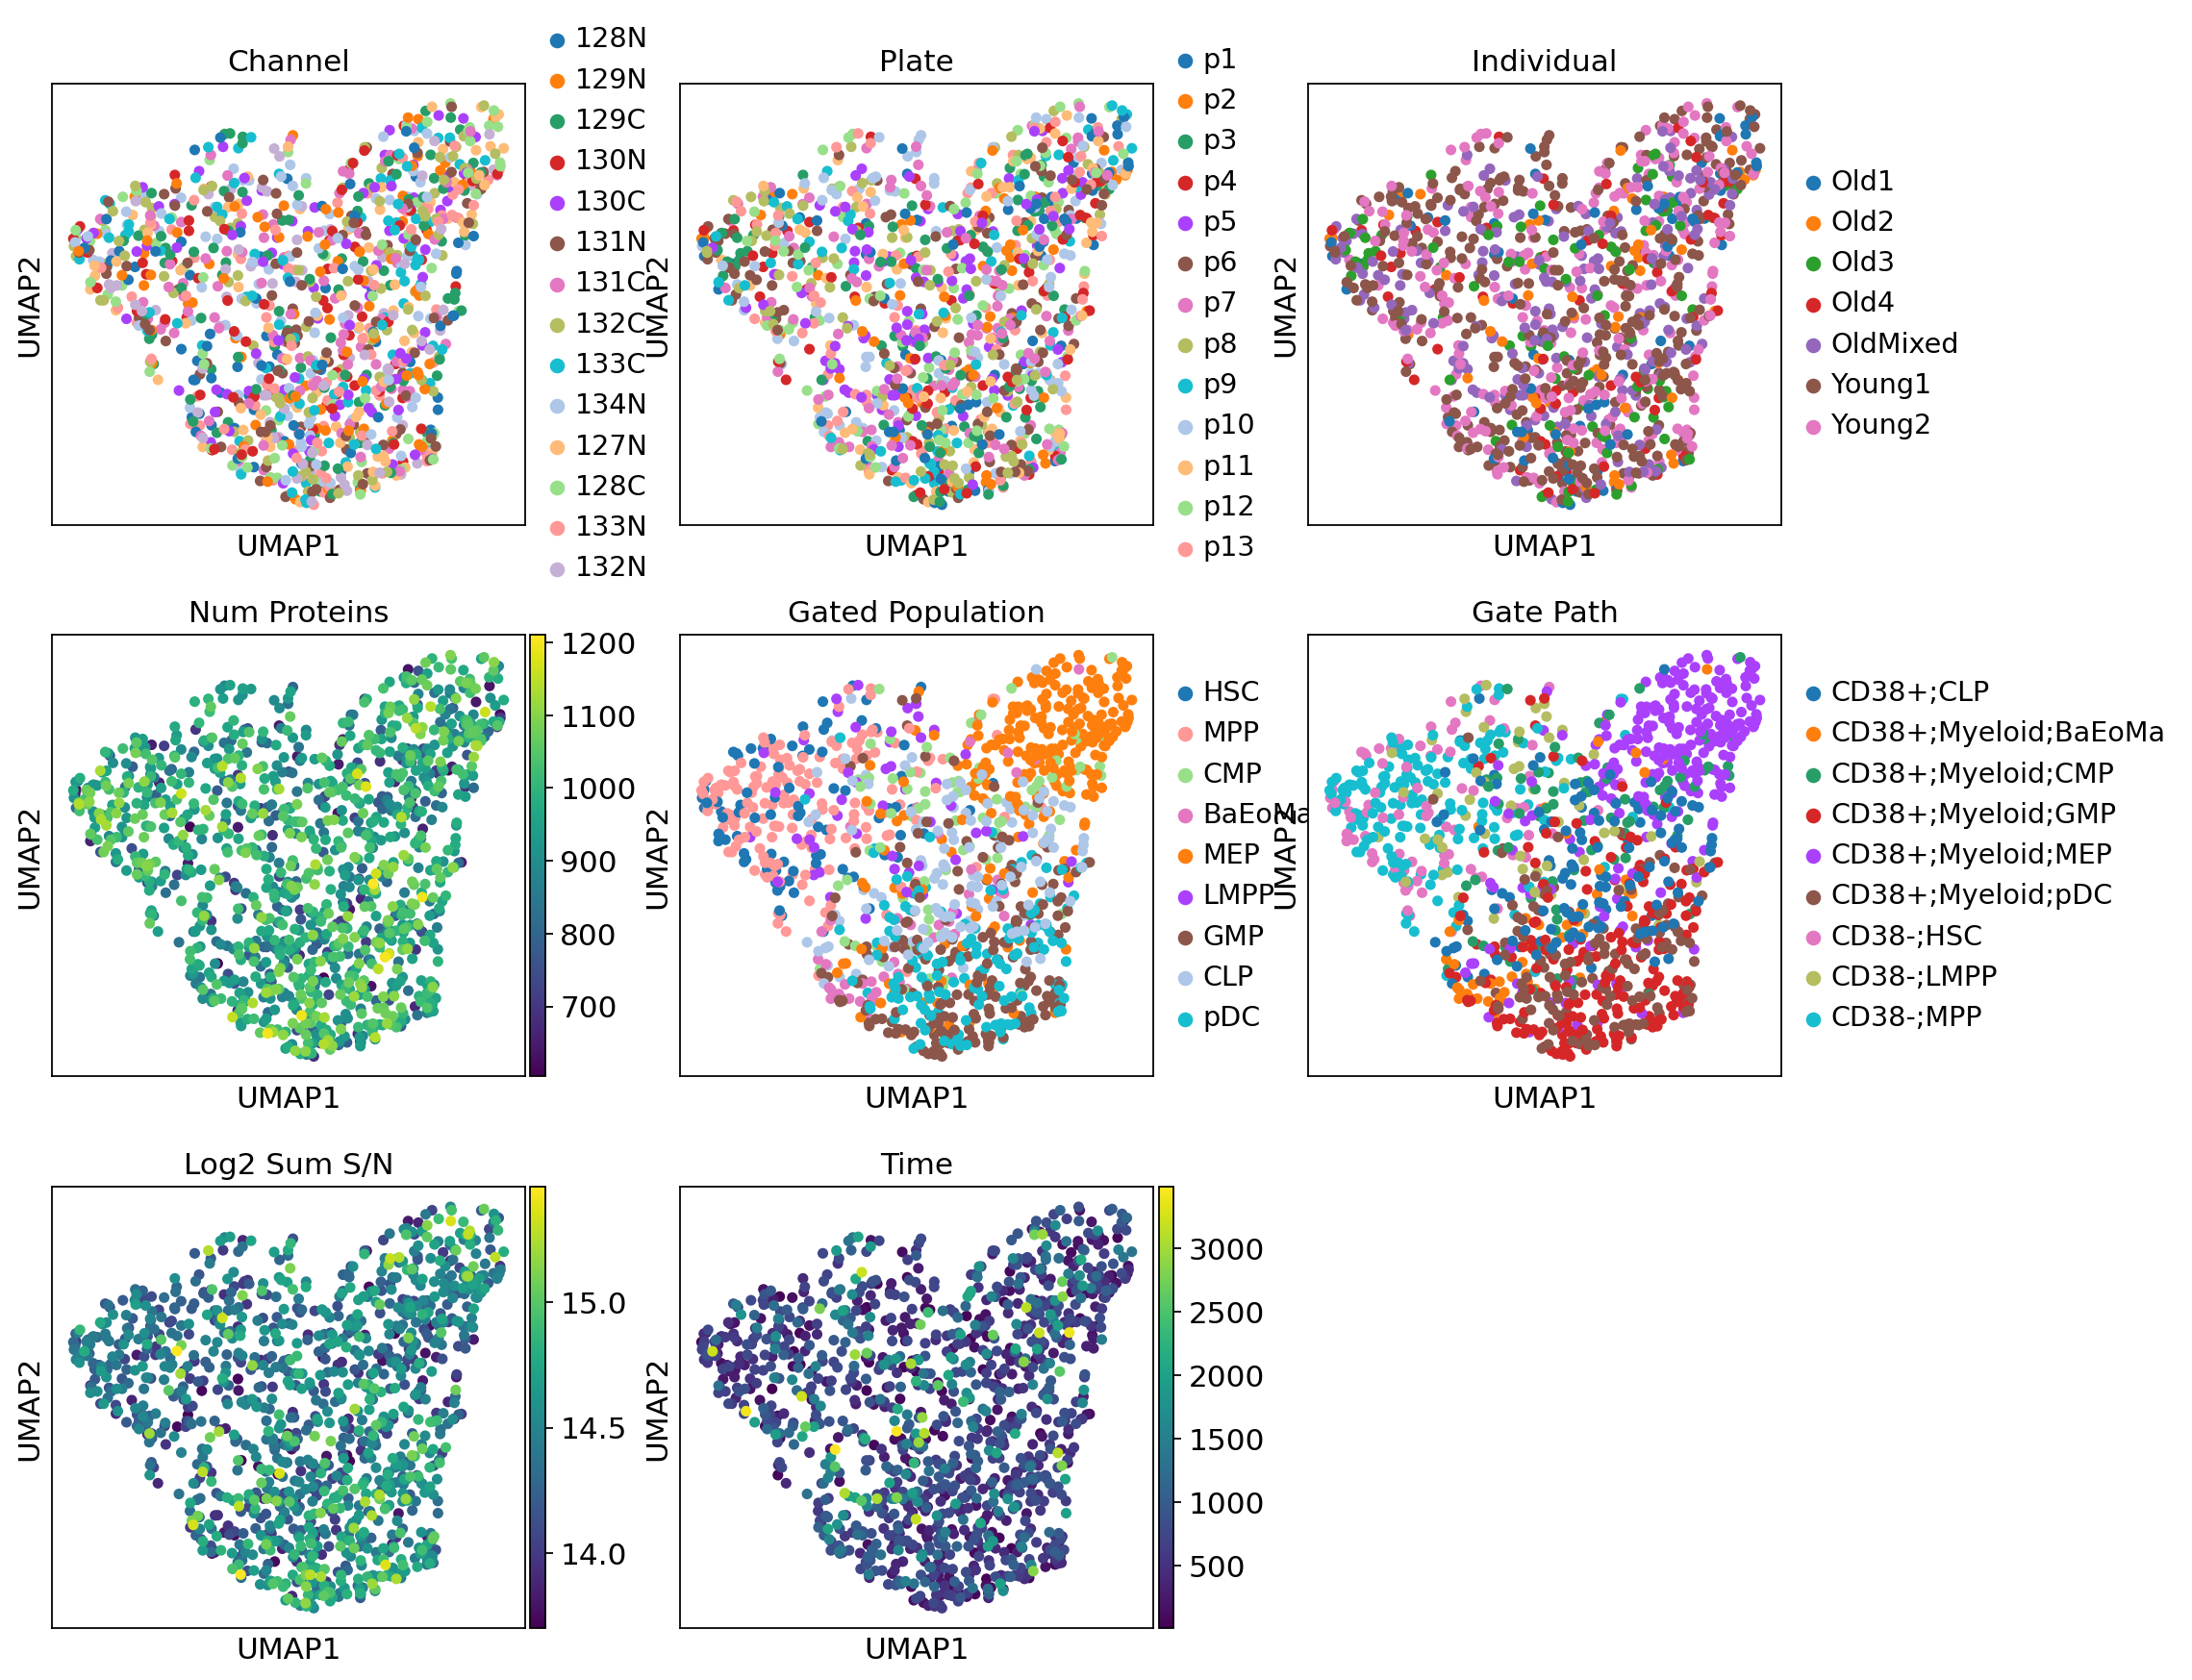

In [21]:
sc.pl.umap(
    adata[~adata.obs["Gated Population"].isin(["ungated"])], 
    color=["Channel", "Plate", "Individual", "Num Proteins", "Gated Population",
          "Gate Path", "Log2 Sum S/N", "Time"], ncols=3
    
)

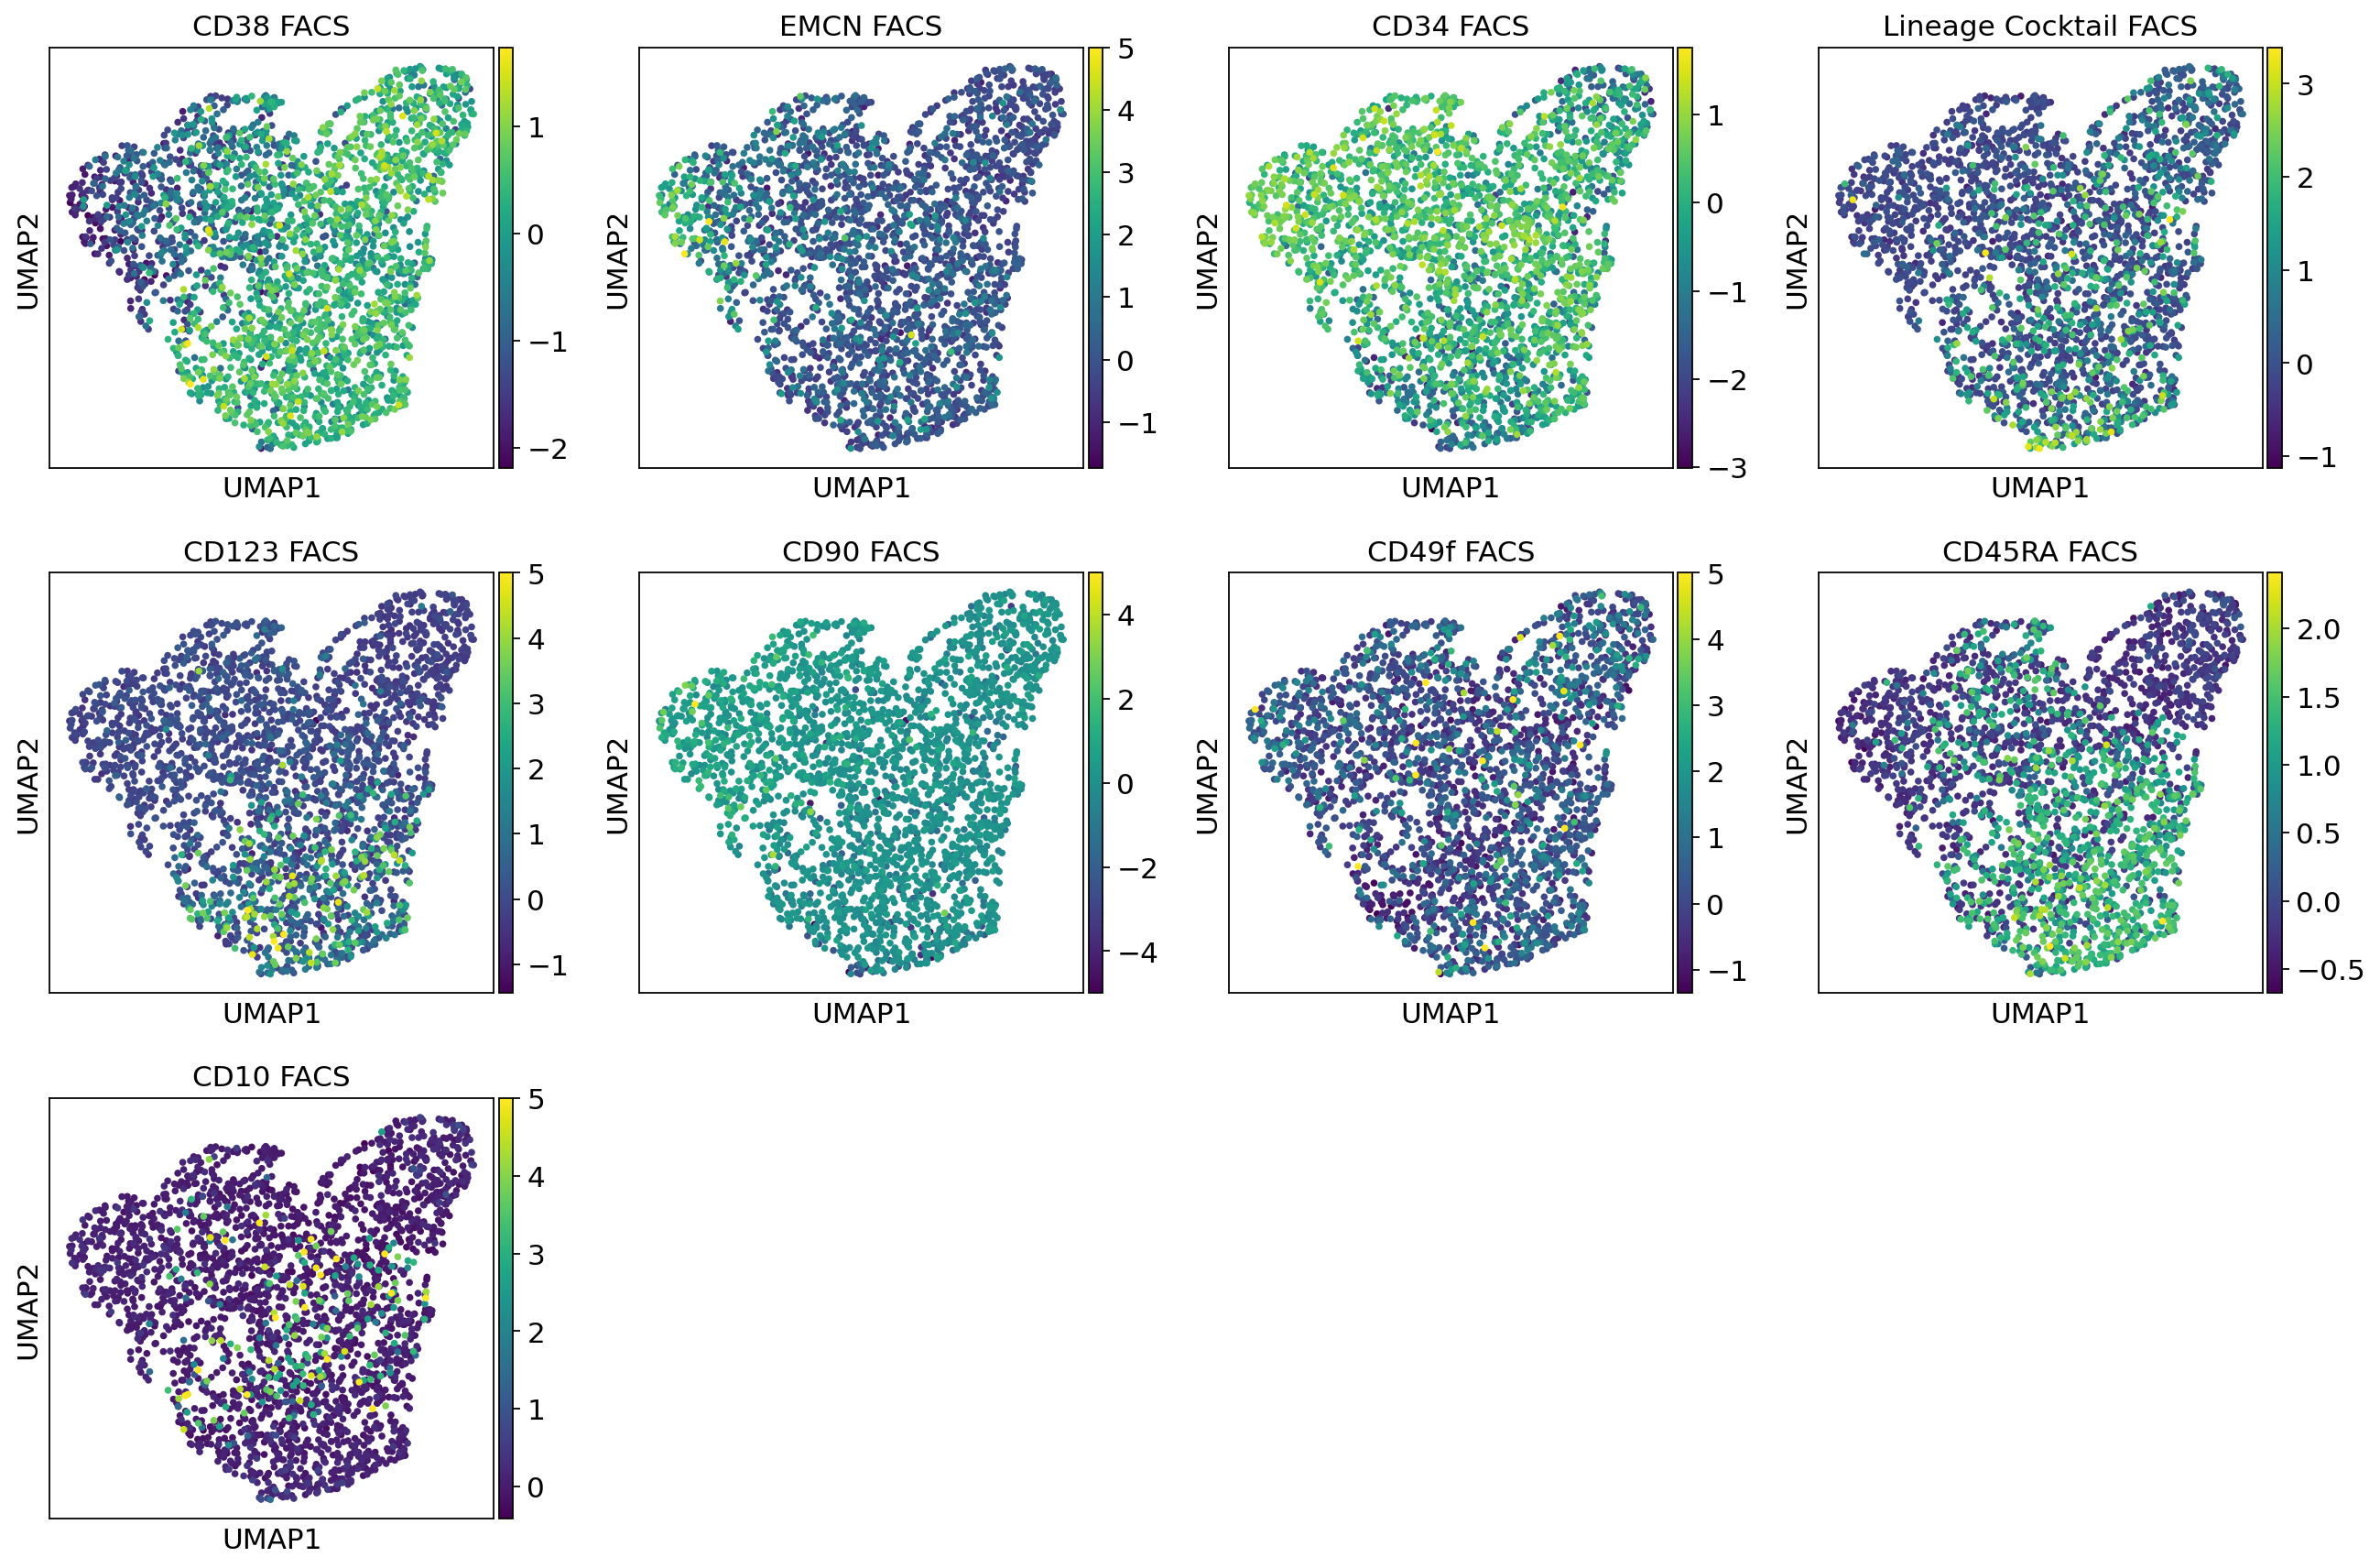

In [22]:
sc.pl.umap(adata, color = [x  for x in adata.obs.columns.tolist() if 'FACS' in x])

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [ ]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [ ]:
r_adata = utils.prepare_anndata_for_R(adata)

In [ ]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw_sn")
dpcfit <- dpc(X)

In [ ]:
protdp_result = robjects.r("dpcfit")

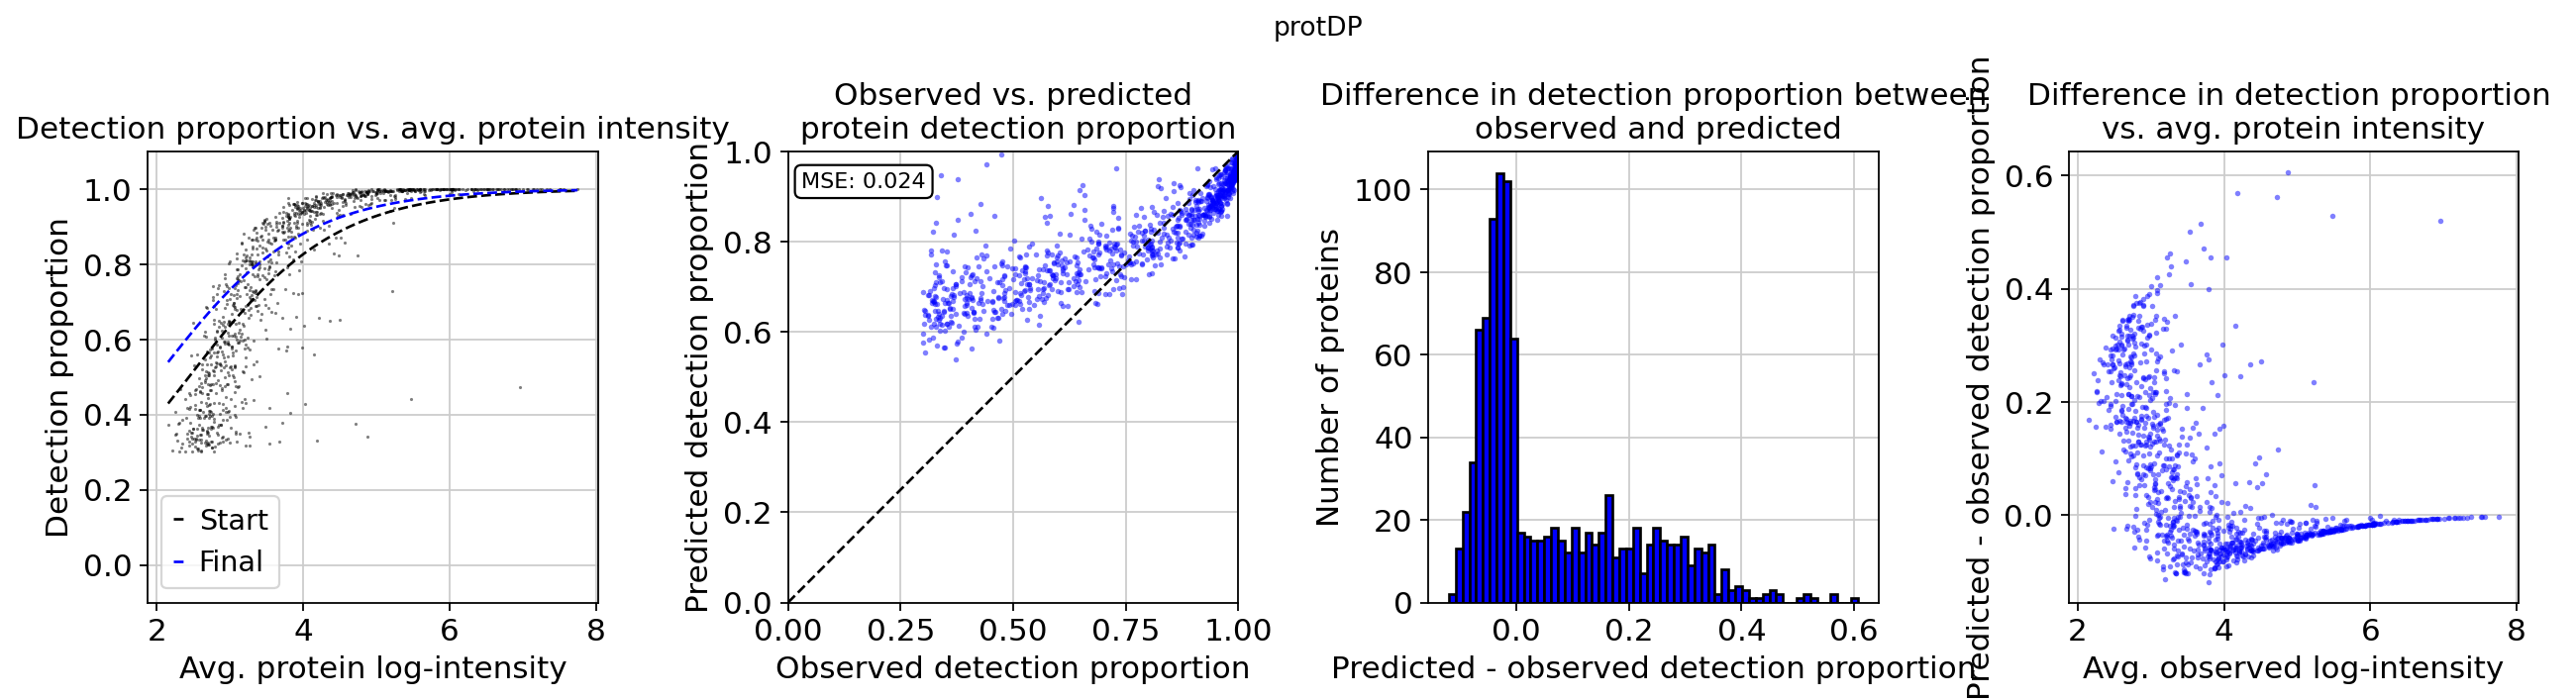

In [ ]:
pl.plot_protein_detection_proportion_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_9571/1935104467.py:8: RuntimeWarning: Mean of empty slice
  x_est_miss_protein = np.nanmean(x_est_miss, axis=0)


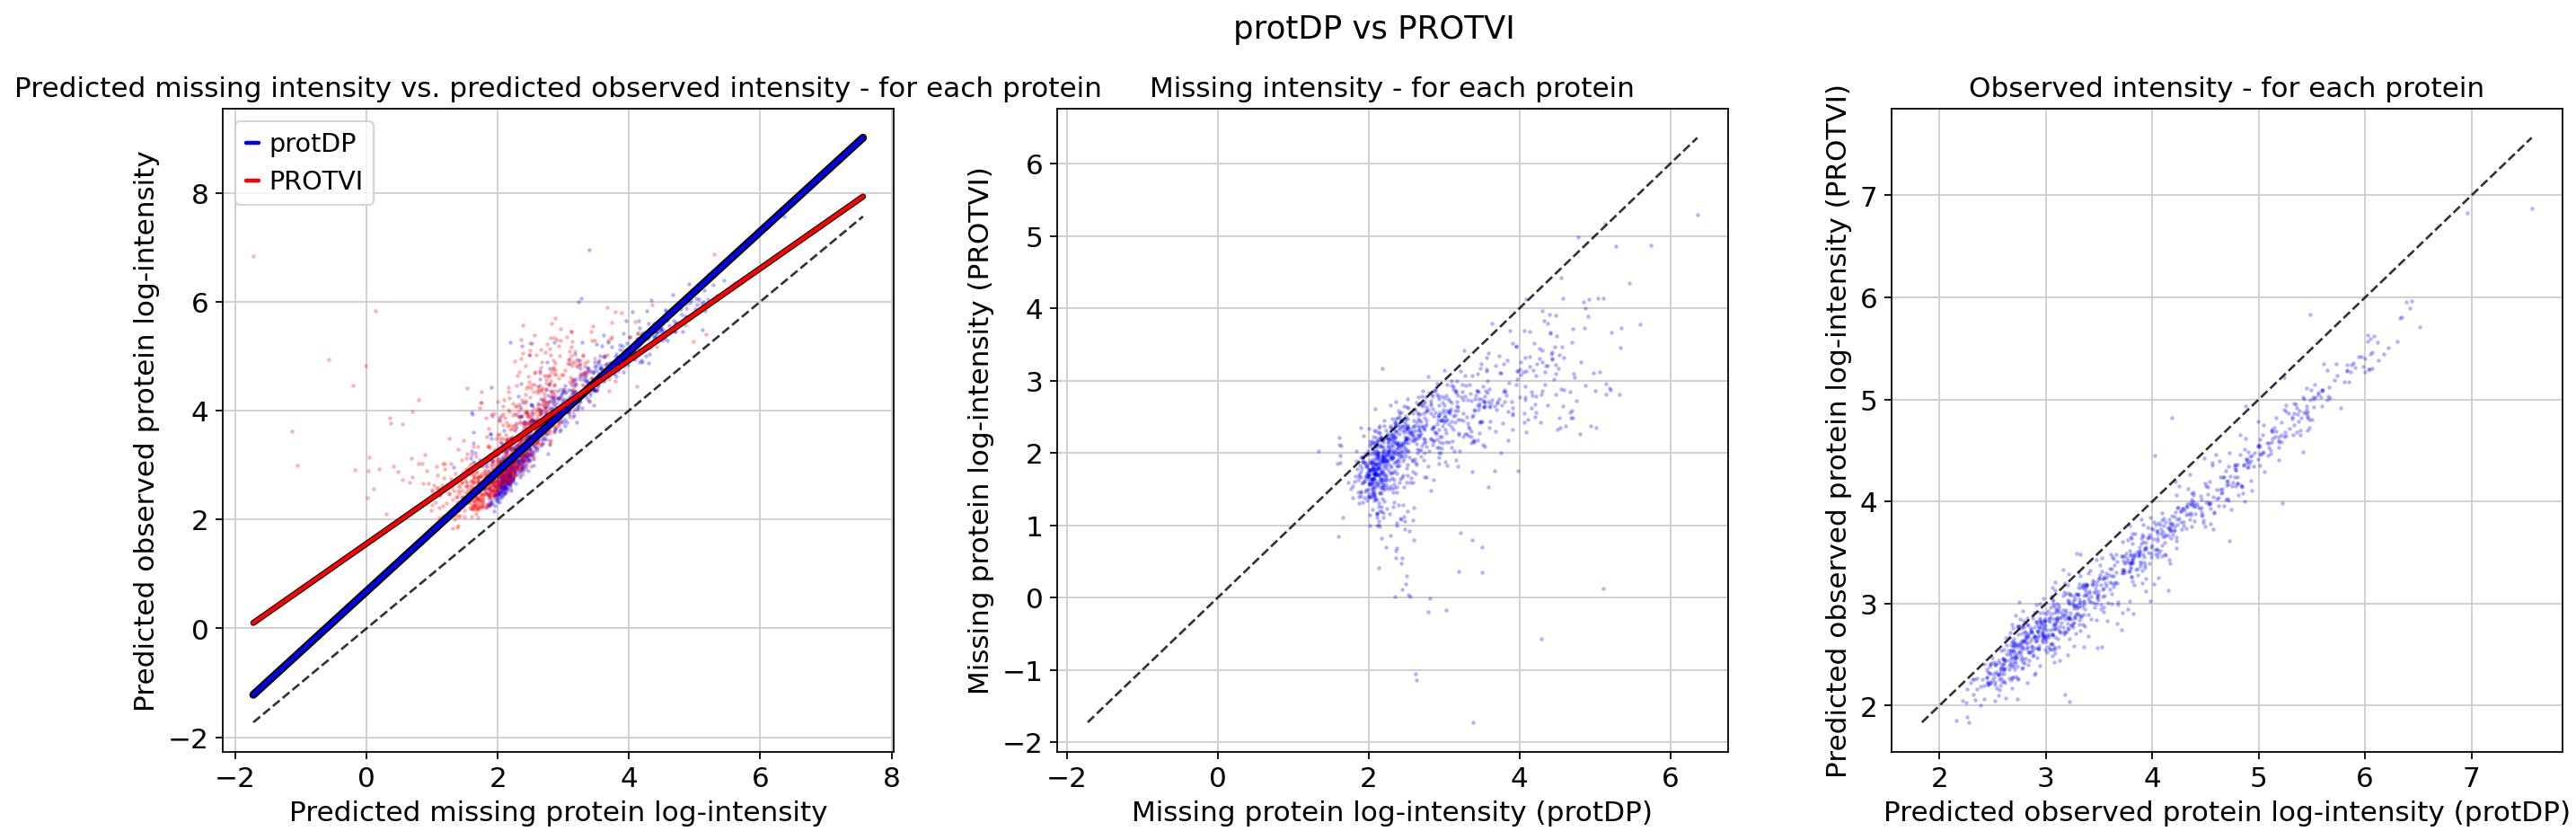

In [ ]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

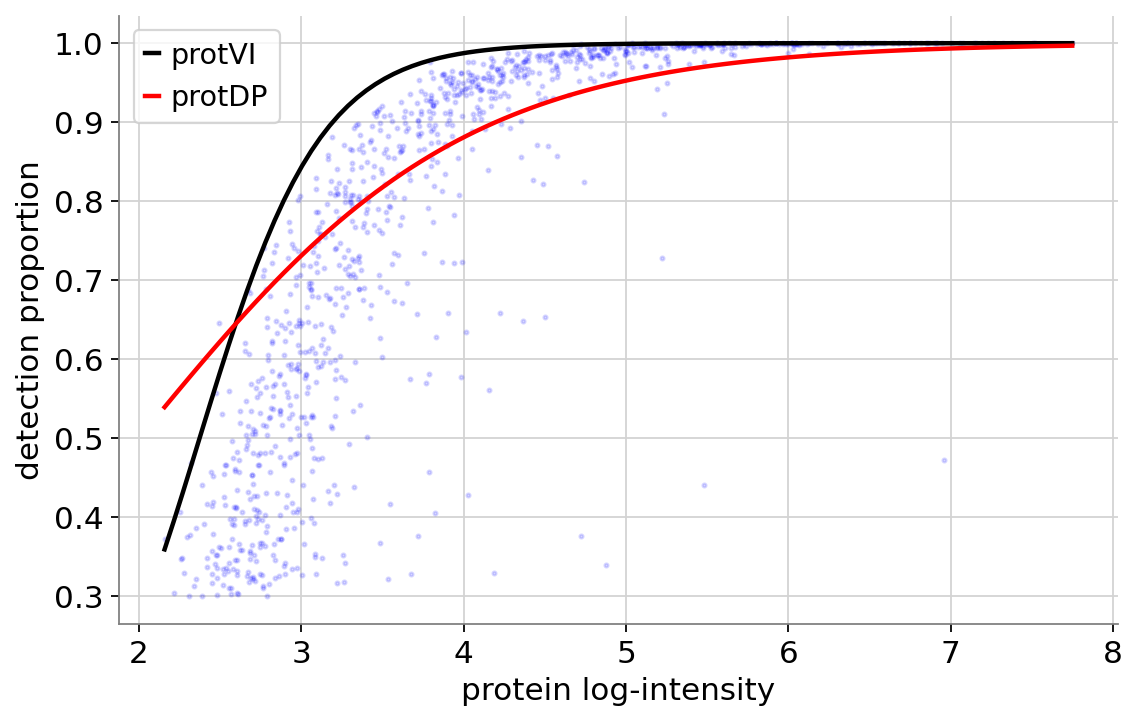

In [ ]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_data, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_data), axis=0)
    p_est_protein = p_est.mean(axis=0)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x_data, ax=ax)

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", label="protVI", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="red", label="protDP", linewidth=2)
    ax.legend()